# Localization_Classification.ipynb
Date: November 29th, 2018  
Course: ECSE415, McGill University  
Authors:  
*Shawn Vosburg  
Tristan Bouchard  
Alex Masciotra  
Nayem Alam  
Thomas Philippon *

## 3. Localization & Classification

In [21]:
#Import the required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import  random as rand
from sklearn.externals import joblib
import csv

#Constants
CLASSIFY_DIM = (128,128)
vehicleName = [
    "articulated_truck", "background", "bicycle",
    "bus", "car", "motorcycle", "non-motorized_vehicle",
    "pedestrian", "pickup_truck", "single_unit_truck", "work_van"                
]

NUM_BUCKETS = 10
IMAGES_PER_BUCKET = 30

In [22]:
def HoGFromImage(img,cs,bs,nb):
    """ This function takes in an image array and HoG param and returns the computed histogram for the image array
        img = image array. all images must be same resolution. 
        cs = cell size in pixel x pixel (height x width)
        bc = bin size in cell x cell (height x width)
        nb = number of bins

    """

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cs[1] * cs[1],
                                      img.shape[0] // cs[0] * cs[0]),
                            _blockSize=(bs[1] * cs[1],
                                        bs[0] * cs[0]),
                            _blockStride=(cs[1], cs[0]),
                            _cellSize=(cs[1], cs[0]),
                            _nbins=nb)
    
    
    n_cells = (img.shape[0] // cs[0], img.shape[1] // cs[1])
        

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - bs[1] + 1,
                            n_cells[0] - bs[0] + 1,
                            bs[0], bs[1], nb) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    #Add each contributions to the histogram.
    for off_y in range(bs[0]):
        for off_x in range(bs[1]):
            gradients[off_y:n_cells[0] - bs[0] + off_y + 1,
                      off_x:n_cells[1] - bs[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - bs[0] + off_y + 1,
                       off_x:n_cells[1] - bs[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

## Create Array containing the boxes of the sliding windows

In [23]:
#Class containging the rectangle shape
class rectangle():
    def __init__(self,x,y,w,h,color):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.color = color
        
#Class to keep the images numbered. Used for accessing csv data later. 
class localizedImage():
    """
    Class will keep image with its name and its bounding rectangles
    """
    def __init__(self,img,name,predRect = None ,gtRect = None):
        """
        img = img data
        name = name of the image (e.g. 00000001)
        predRect = 
        """
        self.img = img
        self.name = name
        self.predRect = predRect
        self.gtRect = gtRect

#sliding window
def slidingWindow(img):
    """
    This function returns a list of sliding windows based on the image's shape. 
    """
    
    #Intialize variables
    windows = []
    scaleFactor = 1.4
    squareSize = 60
    overlap = 0.6
    
    color = [[255,0,0],[0,255,0],[0,0,255]]
    initialSizeOfRectangles = [  #Convention is [xwin,ywin,wwin,hwin]
        [0,0,int(squareSize/342 * img.shape[1]),int(squareSize/342 * img.shape[1]),color[0]], #SQUARE
        [0,0,int(2/ np.sqrt(6) *squareSize/342 * img.shape[1]),int(3/ np.sqrt(6) *squareSize/342 * img.shape[1]),color[1]], #VERTICAL RECTANGLE
        [0,0,int(3/ np.sqrt(6) *squareSize/342 * img.shape[1]),int(2/ np.sqrt(6) *squareSize/342 * img.shape[1]),color[2]], #HORIZONTAL RECTANGLE
    ]
    
    #Build sliding windows
    for inital in initialSizeOfRectangles:
        xwin = inital[0]
        ywin = inital[1]
        wwin = inital[2]
        hwin = inital[3]
        col = inital[4]
        layer = 0
        while ywin < img.shape[1]:
            for xwin in range(0,img.shape[1],int(wwin*(1.0 - overlap))):
                #Ignore the first layer as the windows will be too small
                if(layer == 0):
                    continue
                
                #If the outside of the sliding window is cut off, ignore window
                if (img.shape[1] - xwin) < wwin or (img.shape[0] - ywin) < hwin :
                    continue
                
                #Create window and append to list
                patch = rectangle(xwin,ywin,wwin,hwin,col)
                windows.append(patch)

            #Update sliding window parameters
            ywin = int(ywin + hwin*(1.0-overlap))
            hwin = int(hwin * scaleFactor)
            wwin = int(wwin * scaleFactor)
            layer += 1

    return windows

def find_predRect(img):
    """
    Runs the image with the sliding windows in the classifiers
    Returns the bounding boxes of the detected rectangles and the image displaying the rectangles on them.
    """
    cs = (8,8)
    bs = (2,2)
    nbins = 8
    boundingRect = []
    img1 = img.copy()
    windows = slidingWindow(img)
    for sw in windows:
        patch = img[sw.y:sw.y + sw.h, sw.x:sw.x + sw.w] 
        patch = cv2.resize(patch,CLASSIFY_DIM)
        hog = HoGFromImage(patch,cs,bs,nbins)
        hog = hog.reshape(1,-1)
        labelKneigh = clfKneigh.predict(hog)
        labelSVM = clfSVM.predict(hog)

        #Build Mix Picture
        if(labelKneigh != 1 and labelKneigh != 7 and labelKneigh == labelSVM):
            boundingRect.append(sw)
            cv2.rectangle(img1, (sw.x, sw.y) ,(sw.x + sw.w, sw.y + sw.h), sw.color, 3)
            cv2.putText(img1,vehicleName[labelKneigh[0]] ,(sw.x,sw.y-7), cv2.FONT_HERSHEY_SIMPLEX, 1,sw.color,2,cv2.LINE_AA)
    return boundingRect, img1

imgpath = "./MIO-TCD-Localization/MIO-TCD-Localization/train/00000027.jpg"
img = cv2.imread(imgpath)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
windows = slidingWindow(img)
print(len(windows))
img1 = img.copy()

for sw in windows:
    cv2.rectangle(img1, (sw.x, sw.y) ,(sw.x + sw.w, sw.y + sw.h), sw.color, 3)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(img1)
plt.xticks([]), plt.yticks([])
plt.show()



error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


## Load Classifiers

In [76]:
#Load classifier 
#load path
loadingPath = "./Classifiers/SVM/"
clfFileType = ".clf"
name = "SVMclf"+ "_Main"
path = loadingPath + name +clfFileType
print("Presently loading classifier SVM...",end="")
start = time.time()
clfSVM = joblib.load(path)
end = time.time()
print("DONE! (Time taken:",end-start,"sec)")

loadingPath = "./Classifiers/Kneigh/"
clfFileType = ".clf"
name = "Kneighclf"+ "_Main"
path = loadingPath + name +clfFileType
print("Presently loading classifier Kneigh...",end="")
start = time.time()
clfKneigh = joblib.load(path)
end = time.time()
print("DONE! (Time taken:",end-start,"sec)")



Presently loading classifier SVM...DONE! (Time taken: 0.538954496383667 sec)
Presently loading classifier Kneigh...DONE! (Time taken: 1.2684061527252197 sec)


## Predict which class the labels belong to and print out the resulting image

MIX: non-motorized_vehicle [0, 255, 0]
./MIO-TCD-Localization/MIO-TCD-Localization/train/00000069.jpg


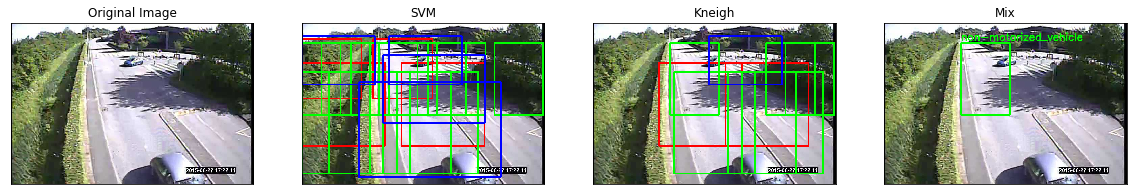

In [164]:
   
print(imgpath)
#Display images on screen
plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(img)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.subplot(142)
plt.imshow(img1)
plt.title("SVM")
plt.xticks([]), plt.yticks([])
plt.subplot(143)
plt.imshow(img2)
plt.title("Kneigh")
plt.xticks([]), plt.yticks([])
plt.subplot(144)
plt.imshow(img3)
plt.title("Mix")
plt.xticks([]), plt.yticks([])
plt.show()

# Keeping track of good parameters/results
**Param 1** :  
    scaleFactor = 1.4  
    squareSize = 60  
    overlap = 0.6  
    *Nice Mix Testcases: 27, 28,92,108,145,174,289,556 (good),1073, 1152, *

In [3]:
def dice_coeff(gtArr,predArr,imgShape):
    """
    Calculates the dice coefficient of each of the ground truth bounding boxes.
    gtArr = array of ground truth label
    """

In [25]:
def fill_predRect(image_matrix):
    """
    Function:    fill_predRect(image_matrix)
    Description: Function to compute the DICE coefficients of a matrix of test images
    Parameters:  image_matrix -  Matrix of objects of class numberedImages() of dimension
                                 10 rows by 30 columns
    
    Returns:     image_matrix - Matrix of objects of class numberedImages(), with the same dimensions
                                as the initial input matrix
                 
    Created by:  Tristan Bouchard, Shawn Vosburg
    Date:        2018-11-27
    """
    # Get input images, in a matrix of size 10 buckets (rows) by 30 columns (images in buckets)
    # For each bucket
    for i in range(image_matrix.shape[0]):
        
        # For each image in bucket
        bucket = image_matrix[i,:]
        for j in range(image_matrix.shape[1]):
            img = bucket[j]
            # Compute bounding rectangles for particular image
            predRect, _ = find_predRect(img)
            # Append predRect list to numberedImage() predRect field
            img.predRect = predRect
        
    return image_matrix

def load_images(path, num_buckets, img_per_bucket):
    """
    Function:    load_images(path, num_buckets, img_per_bucket)
    Description: Function to load images into matrix and initialise matrix of numberedImage() class
    Parameters:  path  ---------- Path to the input images
                 num_buckets ---- Number of buckets in which to separate images --> Becomes a row in the matrix
                 img_per_bucket - Number of images for each bucket --> Fills in a column in the matrix
    
    Returns:     image_matrix - Matrix of objects of class numberedImages(), with dimensions specified
                                as arguments
                 
    Created by:  Tristan Bouchard, Shawn Vosburg
    Date:        2018-11-27
    """
    import os, os.path
    img_index = 0
    img_list = os.listdir(path)
    
    # Create list of images
    image_matrix = [None]*10
    for i in range(num_buckets):
        l = [None]*(img_per_bucket)
        image_matrix[i] = (l)
    
    for i in range(num_buckets):
        
        for j in range(img_per_bucket):
            name = img_list[img_index]
            #img = cv2.imread(os.path.join(path,name))
            img = cv2.imread(path + "/" + name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Remove extension from image name
            name = name[:-4]
            
            # Initialize localisedImage object
            loc_img = localizedImage(img,name)
            
            image_matrix[i][j] = loc_img
            img_index = img_index + 1
    
    return image_matrix

In [26]:
path = "D:/Documents/MIO-TCD-Localization/train"
suh = load_images(path, 10, 30)

00000001


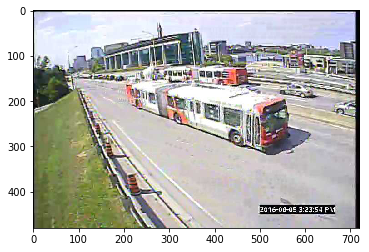

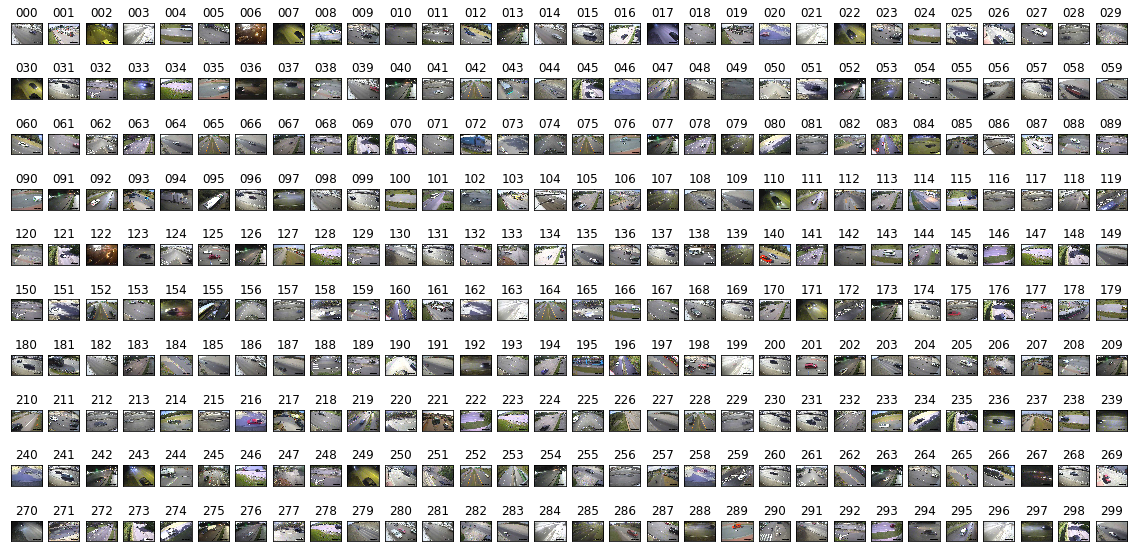

In [46]:
print((suh[0][1].name))
plt.imshow((suh[0][1].img))
plt.show()
acc = 1;
plt.figure(figsize=(20,10))
for i in range(10):
    for j in range(30):
        plt.subplot(10,30,acc), plt.imshow(suh[i][j].img)
        plt.title(suh[i][j].name[5:])
        acc = acc + 1
        plt.xticks([]),plt.yticks([])
plt.show()